# Heat Equation - PINN Procedure

By Zeynep Sağlam, 2024

PINN stands for physics-based neural networks and is often used in scientific calculations, especially in solving differential equations. This procedure was developed as an alternative to traditional numerical analysis methods and is generally effective when data is sparse, noisy, or incomplete. In this notebook, the procedure required to create a  heat equation PINN model. The heat equation is a partial differential equation that describes the temperature of a substance as a function that varies with time. This equation, solved under certain initial and boundary conditions, describes how the temperature distribution of a substance changes over time. This is a classic example of the diffusion equation and plays a crucial role in understanding the principles governing heat transfer and thermal diffusion.

Detailed information about the steps of a PINN model can be found at this [link](https://github.com/saglamzeynep/PINN-Procedure/blob/main/PINN%20Procedure.ipynb).

### Steps to follow:
1) Importing Required Libraries and Defining the Necessary Functions
2) Dataset Creation 
3) Definition of Neural Network Architecture
4) Creation of Physics-Informed Loss Functions
5) Main Program &  Plotting Results

## 1) Importing Required Libraries and Defining the Necessary Functions

In [10]:
import numpy as np
import time
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib import cm
from scipy.stats import qmc
from mpl_toolkits.mplot3d import Axes3D as ax
import seaborn as sns

tf.keras.backend.set_floatx("float64")

In [11]:
#Functions

@tf.function
def u(x,y):
    u=model(tf.concat([x,y],axis=1))
    return u

@tf.function
def f(x,y): 
    u0=u(x,y)
    ux=tf.gradients(u0,x)[0] #The meaning of zero is to take the first of 
    #the outputs of the gradients function, that is, the derivative.
    uy=tf.gradients(u0,y)[0]
    uxx=tf.gradients(ux,x)[0]
    uyy=tf.gradients(uy,y)[0]
    F=uxx+uyy
    return tf.reduce_mean(tf.square(F))

@tf.function
def MSE(y,y_): #mean squared error
    return tf.reduce_mean(tf.square(y-y_))

## 2) Dataset Creation 

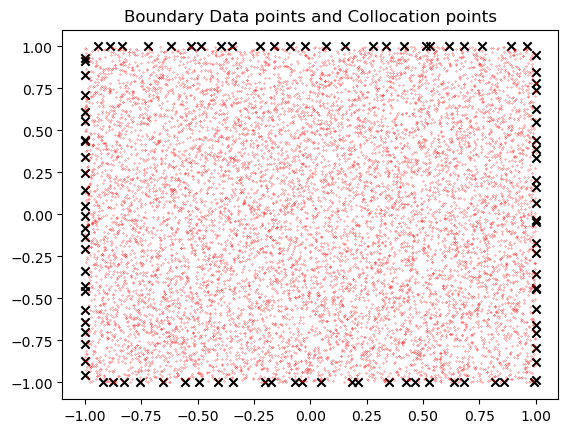

In [12]:
n_bc = 4
n_data_per_bc = 25

engine = qmc.LatinHypercube(d=1)
data = np.zeros([4, 25, 3])

for i, j in zip(range(n_bc), [-1, +1, -1, +1]):
    points = (engine.random(n=n_data_per_bc)[:, 0] - 0.5) * 2
    if i < 2:
        data[i, :, 0] = j
        data[i, :, 1] = points
    else:
        data[i, :, 0] = points
        data[i, :, 1] = j

data[0, :, 2] = 1. #actual degree 100
data[2, :, 2] = 3. #actual degree 300

data = data.reshape(n_data_per_bc * n_bc, 3) #With this process, the data is obtained as a block.


x_d, y_d, t_d = map(lambda x: np.expand_dims(x, axis=1),[data[:, 0], data[:, 1], data[:, 2]])

#Creating random data in the boundry with latinhypercube
Nc = 10000
engine = qmc.LatinHypercube(d=2)
colloc = engine.random(n=Nc)
colloc = 2 * (colloc -0.5) #This process expands the data produced in the range [0,1] to the range [-1,1].

x_c, y_c = map(lambda x: np.expand_dims(x, axis=1), 
               [colloc[:, 0], colloc[:, 1]])

plt.title("Boundary Data points and Collocation points")
plt.scatter(data[:, 0], data[:, 1], marker="x", c="k", label="BDP")
plt.scatter(colloc[:, 0], colloc[:, 1], s=.2, marker=".", c="r", label="CP")
plt.show()

x_c, y_c, x_d, y_d, t_d =map(lambda x: tf.convert_to_tensor(x,dtype=tf.float64),[x_c, y_c, x_d, y_d, t_d])


## 3) Definition of Neural Network Architecture

In [13]:
#model building

def DNN_builder(in_shape=2, out_shape=1, n_hidden_layers=10,neuron_per_layer=20, actfn="tanh"):
    input_layer=tf.keras.layers.Input(shape=(in_shape,))  #The comma is necessary to 
    #create a tuple, if we write it without a comma, in_shape will be perceived as just 
    #a number and the size of the input data cannot be adjusted as desired.
    
    hidden_layer=[tf.keras.layers.Dense(neuron_per_layer,activation=actfn)(input_layer)]
    
    for i in range(n_hidden_layers-1):
        new_layer=tf.keras.layers.Dense(neuron_per_layer,activation=actfn,activity_regularizer=None)(hidden_layer[-1])
        hidden_layer.append(new_layer)
    
    output_layer=tf.keras.layers.Dense(1,activation=None)(hidden_layer[-1])
    name=f"DNN-{n_hidden_layers}"
    model=tf.keras.Model(input_layer, output_layer, name=name)
    return model

In [14]:
tf.keras.backend.clear_session()
model=DNN_builder()
model.summary()

Model: "DNN-10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 dense (Dense)               (None, 20)                60        
                                                                 
 dense_1 (Dense)             (None, 20)                420       
                                                                 
 dense_2 (Dense)             (None, 20)                420       
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 20)                420  

## 4) Creation of Physics-Informed Loss Functions

    0,2.536
  100,0.561
  200,0.312
  300,0.190
  400,0.172
  500,0.162
  600,0.154
  700,0.148
  800,0.145
  900,0.139
 1000,0.136
It takes  8.593480587005615  minutes


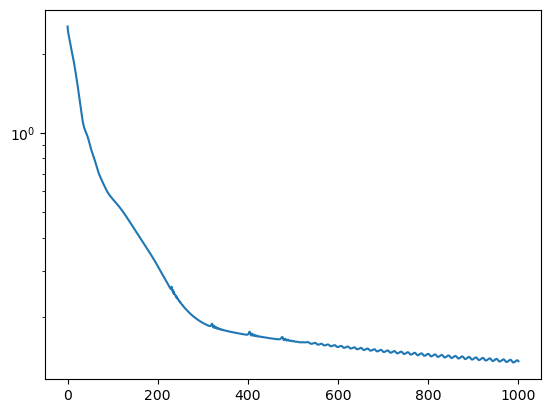

In [15]:
#Loss function

loss=0
epoch=1001
optimizer= tf.keras.optimizers.Adam(learning_rate=5e-4)

loss_val=np.array([])

start = time.time()
for i in range(epoch):
    with tf.GradientTape() as tape:
        T=u(x_d,y_d)  # Temperature data created from boundary
        L=f(x_c,y_c)  # Losses from created x-y points
        l=MSE(t_d,T) 
        
        loss=L+l
        
    g=tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(g, model.trainable_weights))
    loss_val=np.append(loss_val,loss)
    if i % 100 ==0:
        print(f"{i:5},{loss.numpy():.3f}")
        
end = time.time()
plt.semilogy(loss_val, label=model.name)

print("It takes ",(end-start)/60," minutes")


## 5) Main Program &  Plotting Results

In [16]:
### plotting
n=100
plt.figure("", figsize=(12, 6))

X = np.linspace(-1, +1, n)
Y = np.linspace(-1, +1, n)
X0, Y0 = np.meshgrid(X, Y)
X = X0.reshape([n*n, 1])
Y = Y0.reshape([n*n, 1])
X_T = tf.convert_to_tensor(X)
Y_T = tf.convert_to_tensor(Y)
S = u(X_T, Y_T)
S = S.numpy().reshape(n, n)

<Figure size 1200x600 with 0 Axes>

6.451808679857216e-07


/tmp/ipykernel_31099/3516631873.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout( pad=2.5)


(-1.0101010101010102,
 1.0101010101010097,
 -1.0101010101010102,
 1.0101010101010097)

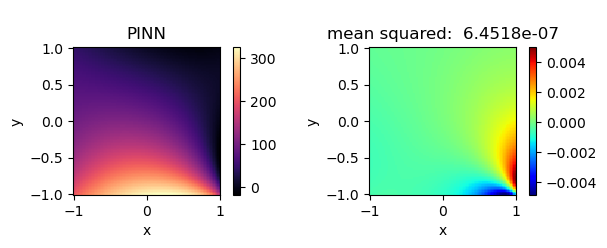

In [17]:
plt.subplot(221)
plt.pcolormesh(X0, Y0, 100.*S, cmap="magma")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title("PINN")
plt.tight_layout()
plt.axis("square")

plt.subplot(222)
pinn_grad = np.gradient(np.gradient(S, axis=0), axis=1)
sigma_pinn = (pinn_grad**2).mean()
print(sigma_pinn)
plt.pcolormesh(X0, Y0, pinn_grad, cmap="jet")
plt.colorbar()
plt.xlabel("x")
plt.ylabel("y")
plt.title(f"\nmean squared: {sigma_pinn: .4e}")
plt.tight_layout( pad=2.5)
plt.axis("square")